In [75]:
from pathlib import Path
import os
import numpy as np
import copy
import matplotlib.pyplot as plt
from ddgclib._complex import Complex
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._curvatures import b_curvatures_hn_ij_c_ij
from data_levelset_geometric_shapes.extract_and_process_interface_points import read_data, \
    extract_and_save_unique_intersection_points, plot_intersection_points, plot_unique_intersections,\
    plot_and_save_levelset_points

def distance_matrix(A, B, squared=False):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.

    See also
    --------
    A more generalized version of the distance matrix is available from
    scipy (https://www.scipy.org) using scipy.spatial.distance_matrix,
    which also gives a choice for p-norm.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

def cotan(theta):
    return 1 / np.tan(theta)


def plot_intersections(axes, intersections, corners, plot_thick):
   number_of_inter = len(intersections)
   for idx in range(0, number_of_inter):
      this_inter       = intersections[idx]
      this_inter_faces = find_cell_faces(this_inter, corners)
      for nxt_idx in range(idx+1, number_of_inter):
         next_inter       = intersections[nxt_idx]
         next_inter_faces = find_cell_faces(next_inter, corners)

         if len(this_inter_faces.intersection(next_inter_faces)) > 0:
            if plot_thick:
               axes.plot( [this_inter[0], next_inter[0]], [this_inter[1], next_inter[1]], [this_inter[2], next_inter[2]], marker="x", markersize=1.5, linewidth=0.5, color = "red")
            else:
               axes.plot( [this_inter[0], next_inter[0]], [this_inter[1], next_inter[1]], [this_inter[2], next_inter[2]], marker="x", markersize=0.25, linewidth=0.25, color = "red")

def find_cell_faces(intersection_point, cell_corners):
    all_sides = [
       0 if intersection_point[0] == cell_corners[0][0] else None,
       1 if intersection_point[0] == cell_corners[6][0] else None,
       2 if intersection_point[1] == cell_corners[0][1] else None,
       3 if intersection_point[1] == cell_corners[6][1] else None,
       4 if intersection_point[2] == cell_corners[0][2] else None,
       5 if intersection_point[2] == cell_corners[6][2] else None
       ]
    #return set([side for side in all_sides if side is not None])
    return [side for side in all_sides if side is not None]


def f_ijk(nverts):
    # Returns the F_ijk matrix of faces depending on the number of vertices 
    if 0:
        # The number of edges e_dim
        e_dim_l = []
        e_dim = e_dim_l
        if nverts == 3:
            e_dim = 3
        elif nverts == 3:
            e_dim = 3
    F_ijk = np.zeros([nverts - 2, 3], dtype=int)
    if nverts == 3:
        F_ijk[:] = [0, 1, 2]
    elif nverts == 4:  # 2 simplices
        F_ijk[0, :] = [0, 1, 2]
        F_ijk[1, :] = [0, 2, 3]
    elif nverts == 5:  # 3 simplices
        F_ijk[0, :] = [0, 1, 2]
        F_ijk[1, :] = [0, 2, 4]
        F_ijk[2, :] = [2, 3, 4]
    elif nverts == 6:  # 4 simplices
        F_ijk[0, :] = [0, 1, 2]
        F_ijk[1, :] = [0, 2, 4]
        F_ijk[2, :] = [2, 3, 4]
        F_ijk[3, :] = [0, 3, 4]
        
    return F_ijk  #[0]

def assign_incides(intersections, corners):
    # Return ordered points and connectivity matrix E_ij
    nverts = intersections.shape[0]  # number of intersection in current cell
    pf_indices = []
    pind = 0
    pind_order = []  # or int dtype array of size intersections.shape[0] 
    # Compute the faces 
    for p in intersections:
        pi = find_cell_faces(p, corners)
        pf_indices.append(pi)
        
    # Find the correct order of points of the intersections
    pind_order.append(0)  # Arbitarily select the first point
    pind = 0  # Previous index
    cf = pf_indices[0][0]  # current face
    while len(pind_order) < nverts:  
        for i in range(len(pf_indices)):
            if i == pind:
                continue
            ci = pf_indices[i]
            if cf == ci[0]:
                pind_order.append(i)
                cf = ci[1]  # move on to new face
                pind = i  # Make i the previous index for the next loop
                break
            elif cf == ci[1]:
                pind_order.append(i)
                cf = ci[0]  # move on to new face
                pind = i  # Make i the previous index for the next loop
                break
                
    F_ijk = f_ijk(nverts)  # Triangles present in current cell
    return pind_order, f_ijk(nverts)

In [76]:
filename = Path("../../ddgclib/data_levelset_geometric_shapes/sphere_coarse/extraction_data_0.000000.txt")
result_folder = Path("../../ddgclib/data_levelset_geometric_shapes/X_intersections_sphere_coarse")
plot_single_cells = False

# Create the result folder
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [77]:
# Read and plot the data
corners_and_intersections = read_data(filename)
#unique_intersections = extract_and_save_unique_intersection_points(corners_and_intersections, result_folder)
#plot_and_save_levelset_points(corners_and_intersections, result_folder)
#plot_unique_intersections(unique_intersections, result_folder)
#plot_intersection_points(corners_and_intersections, result_folder, plot_single_cells)

cell_corners_and_intersections = corners_and_intersections
def intersection_is_found(intersection, ref_intersections):
    return any([all([np.abs(coord - coord_ref) <= 1e-14 for coord, coord_ref in zip(intersection, ref_inter)]) for ref_inter in ref_intersections])
    # Get unique intersections
all_intersections    = [inter for data in cell_corners_and_intersections for inter in data["Intersections"]]
unique_intersections = np.unique(np.array(all_intersections), axis=0)
f_ijk(3), f_ijk(4), f_ijk(5), f_ijk(6)

Total number of cells          :  128
Total number of intersections  :  504
Total number of levelset points:  128


(array([[0, 1, 2]]),
 array([[0, 1, 2],
        [0, 2, 3]]),
 array([[0, 1, 2],
        [0, 2, 4],
        [2, 3, 4]]),
 array([[0, 1, 2],
        [0, 2, 4],
        [2, 3, 4],
        [0, 3, 4]]))

# Global-local approach with hash tables

In [78]:
# Hash table of intersection indices
# This is a global hash table of all intersections points. 
# If computing only one local cell is desired, then at minimum 
# the 9 surrounding cells need to be included for curvature to 
# have physical meaning.
points_hash = {}
points_glob = []
#X = []
#HC = Complex(3)

i = 0
for index, c in enumerate(cell_corners_and_intersections):
    corners       = c["Corners"]
    intersections = c["Intersections"]
    for p in intersections:
        try:
            points_hash[tuple(p)]
        except KeyError:
            points_hash[tuple(p)] = i
            i = i + 1
            points_glob.append(p)
        
points_glob = np.array(points_glob)
points_hash, points_glob

({(0.375, 0.43577986660211937, 0.5): 0,
  (0.37388193871477254, 0.4375, 0.5): 1,
  (0.375, 0.4375, 0.49514238659853893): 2,
  (0.375, 0.4375, 0.5048576134014611): 3,
  (0.375, 0.49514238659853893, 0.4375): 4,
  (0.37388193871477254, 0.5, 0.4375): 5,
  (0.375, 0.5, 0.43577986660211937): 6,
  (0.35906901088337206, 0.5, 0.5): 7,
  (0.375, 0.49514238659853893, 0.5625): 8,
  (0.37388193871477254, 0.5, 0.5625): 9,
  (0.375, 0.5, 0.5642201333978807): 10,
  (0.375, 0.5048576134014611, 0.4375): 11,
  (0.37388193871477254, 0.5625, 0.5): 12,
  (0.375, 0.5625, 0.49514238659853893): 13,
  (0.375, 0.5048576134014611, 0.5625): 14,
  (0.375, 0.5625, 0.5048576134014611): 15,
  (0.375, 0.5642201333978807, 0.5): 16,
  (0.4375, 0.37388193871477254, 0.5): 17,
  (0.43577986660211937, 0.375, 0.5): 18,
  (0.4375, 0.375, 0.49514238659853893): 19,
  (0.4375, 0.375, 0.5048576134014611): 20,
  (0.4375, 0.3927393204260994, 0.4375): 21,
  (0.3927393204260994, 0.4375, 0.4375): 22,
  (0.4375, 0.4375, 0.39273932042609

In [79]:
points_hash[(0.6261180612852275, 0.5625, 0.5)] , points_glob[125]

(125, array([0.62611806, 0.5625    , 0.5       ]))

In [113]:
def e_ij(nverts):
    # Returns the E_ij graph of edges depending on the number of vertices 
    # use std::set for the final version
    if nverts == 3:
        E_ij = [[1, 2],  # edges connected to vertex 0
                [0, 2],  # edges connected to vertex 1
                [0, 1],  # edges connected to vertex 2
               ] 
    elif nverts == 4:  # 2 simplices
        E_ij = [[1, 2, 3],  # edges connected to vertex 0
                [0, 2],  # edges connected to vertex 1
                [0, 1, 3],  # edges connected to vertex 2
                [0, 2],  # edges connected to vertex 3
               ] 
    elif nverts == 5:  # 3 simplices
        E_ij = [[1, 2, 4],  # edges connected to vertex 0
                [0, 2],  # edges connected to vertex 1
                [0, 1, 3, 4],  # edges connected to vertex 2
                [2, 4],  # edges connected to vertex 3
                [0, 2, 3],  # edges connected to vertex 4
               ] 
    elif nverts == 6:  # 4 simplices
        E_ij = [[1, 2, 4, 5],  # edges connected to vertex 0
                [0, 2],  # edges connected to vertex 1
                [0, 1, 3, 4],  # edges connected to vertex 2
                [2, 4],  # edges connected to vertex 3
                [0, 2, 3, 5],  # edges connected to vertex 4
                [0, 4],  # edges connected to vertex 5
               ] 
    return E_ij  #[0]

e_ij(3), e_ij(4), e_ij(5), e_ij(6)

([[1, 2], [0, 2], [0, 1]],
 [[1, 2, 3], [0, 2], [0, 1, 3], [0, 2]],
 [[1, 2, 4], [0, 2], [0, 1, 3, 4], [2, 4], [0, 2, 3]],
 [[1, 2, 4, 5], [0, 2], [0, 1, 3, 4], [2, 4], [0, 2, 3, 5], [0, 4]])

In [81]:
def assign_incides_graph(intersections, corners):
    # Return ordered points and connectivity matrix E_ij
    nverts = intersections.shape[0]  # number of intersection in current cell
    pf_indices = []
    pind = 0
    pind_order = []  # or int dtype array of size intersections.shape[0] 
    # Compute the faces 
    for p in intersections:
        pi = find_cell_faces(p, corners)
        pf_indices.append(pi)
        
    # Find the correct order of points of the intersections
    pind_order.append(0)  # Arbitarily select the first point
    pind = 0  # Previous index
    cf = pf_indices[0][0]  # current face
    while len(pind_order) < nverts:  
        for i in range(len(pf_indices)):
            if i == pind:
                continue
            ci = pf_indices[i]
            if cf == ci[0]:
                pind_order.append(i)
                cf = ci[1]  # move on to new face
                pind = i  # Make i the previous index for the next loop
                break
            elif cf == ci[1]:
                pind_order.append(i)
                cf = ci[0]  # move on to new face
                pind = i  # Make i the previous index for the next loop
                break
                
    F_ijk = f_ijk(nverts)  # Triangles present in current cell
    E_ij = e_ij(nverts)  # Edges present in current cell
    
    return pind_order, F_ijk, E_ij

In [82]:
p, F_ijk_local, E_ij_local = assign_incides_graph(intersections, corners)
points = intersections[p]
p, F_ijk_local, E_ij_local

([0, 2, 1], array([[0, 1, 2]]), [[1, 2], [0, 2], [0, 1]])

# Local to global indices

In [83]:
points_glob.shape

(126, 3)

In [84]:
E_ij = []
for i in range(points_glob.shape[0]):  # for the number of points currently in global pool
    E_ij.append(set())


In [85]:
E_ij_local

[[1, 2], [0, 2], [0, 1]]

In [86]:
points#[pi]

array([[0.62611806, 0.5625    , 0.5       ],
       [0.625     , 0.5625    , 0.50485761],
       [0.625     , 0.56422013, 0.5       ]])

In [87]:
# get global incides
for pi in p:  # Loop for the index of each local point
  #  print(points[pi])
    i = points_hash[tuple(points[pi])]  # Get the global index
    print(f'i = {i}')
   # print( points_glob[i])
    
    for pj in E_ij_local[pi]:  # loop local connects
        if pi == pj:
            continue
        print(f' pj = {pj}')
        j = points_hash[tuple(points[pj])]  # Find global index of connection j
        print(f' j = {j}')
        E_ij[i].add(j)
    #E_ij
   
    
points

i = 125
 pj = 1
 j = 118
 pj = 2
 j = 119
i = 119
 pj = 0
 j = 125
 pj = 1
 j = 118
i = 118
 pj = 0
 j = 125
 pj = 2
 j = 119


array([[0.62611806, 0.5625    , 0.5       ],
       [0.625     , 0.5625    , 0.50485761],
       [0.625     , 0.56422013, 0.5       ]])

In [88]:
E_ij

[set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {119, 125},
 {118, 125},
 set(),
 set(),
 set(),
 set()

In [89]:
for j in E_ij_local[pi]:
    print(j)

0
2


In [90]:
E_ij_local

[[1, 2], [0, 2], [0, 1]]

In [103]:
len(cell_corners_and_intersections)

128

# Wrapping up: return connectivity graph from cells

In [114]:
def glob_hash(cell_corners_and_intersections):
    # Hash table of intersection indices
    # This is a global hash table of all intersections points. 
    # If computing only one local cell is desired, then at minimum 
    # the 9 surrounding cells need to be included for curvature to 
    # have physical meaning.
    points_hash = {}
    points_glob = []  # or a n x 3 array, where n is the total number of points    
    i = 0
    for index, c in enumerate(cell_corners_and_intersections):
        corners       = c["Corners"]
        intersections = c["Intersections"]
        for p in intersections:
            try:
                points_hash[tuple(p)]
            except KeyError:
                points_hash[tuple(p)] = i
                i = i + 1
                points_glob.append(p)  # or set row i vector equal to p
        
    points_glob = np.array(points_glob)  # convert list of points to array
    return points_hash, points_glob

def E_ij_cells(cell_corners_and_intersections):
    for index, c in enumerate(cell_corners_and_intersections):
        corners       = c["Corners"]
        intersections = c["Intersections"]
        p, F_ijk_local, E_ij_local = assign_incides_graph(intersections, corners)
        points = intersections[p]  # Local points in correct order
        # get global incides
        for pi in p:  # Loop for the index of each local point
            i = points_hash[tuple(points[pi])]  # Get the global index
            for pj in E_ij_local[pi]:  # loop local connects
                if pi == pj:
                    continue
                j = points_hash[tuple(points[pj])]  # Find global index of connection j
                E_ij[i].add(j)
    return E_ij

In [115]:
def triangulate_cells(cell_corners_and_intersections):
    #ncells = len(cell_corners_and_intersections)  # Number of cells currently under consideration
    #for i in range(ncells):
    # Compute the hash table of all points currently in cell_corners_and_intersections:
    points_hash, points_glob = glob_hash(cell_corners_and_intersections)
    
    # For each cell, 
    E_ij = E_ij_cells(cell_corners_and_intersections)
    
    return points_hash, points_glob, E_ij

points_hash, points_glob, E_ij =  triangulate_cells(cell_corners_and_intersections)
points_hash, points_glob, E_ij


({(0.375, 0.43577986660211937, 0.5): 0,
  (0.37388193871477254, 0.4375, 0.5): 1,
  (0.375, 0.4375, 0.49514238659853893): 2,
  (0.375, 0.4375, 0.5048576134014611): 3,
  (0.375, 0.49514238659853893, 0.4375): 4,
  (0.37388193871477254, 0.5, 0.4375): 5,
  (0.375, 0.5, 0.43577986660211937): 6,
  (0.35906901088337206, 0.5, 0.5): 7,
  (0.375, 0.49514238659853893, 0.5625): 8,
  (0.37388193871477254, 0.5, 0.5625): 9,
  (0.375, 0.5, 0.5642201333978807): 10,
  (0.375, 0.5048576134014611, 0.4375): 11,
  (0.37388193871477254, 0.5625, 0.5): 12,
  (0.375, 0.5625, 0.49514238659853893): 13,
  (0.375, 0.5048576134014611, 0.5625): 14,
  (0.375, 0.5625, 0.5048576134014611): 15,
  (0.375, 0.5642201333978807, 0.5): 16,
  (0.4375, 0.37388193871477254, 0.5): 17,
  (0.43577986660211937, 0.375, 0.5): 18,
  (0.4375, 0.375, 0.49514238659853893): 19,
  (0.4375, 0.375, 0.5048576134014611): 20,
  (0.4375, 0.3927393204260994, 0.4375): 21,
  (0.3927393204260994, 0.4375, 0.4375): 22,
  (0.4375, 0.4375, 0.39273932042609

In [120]:
# Test the triangluation retrieved with hyperct library
HC = Complex(3)
i = 0
for pi in points_glob:
    for j in E_ij[i]:
        vi = HC.V[tuple(pi)]
        vj = HC.V[tuple(points_glob[j])]
        vi.connect(vj)
    i = i + 1

<IPython.core.display.Javascript object>


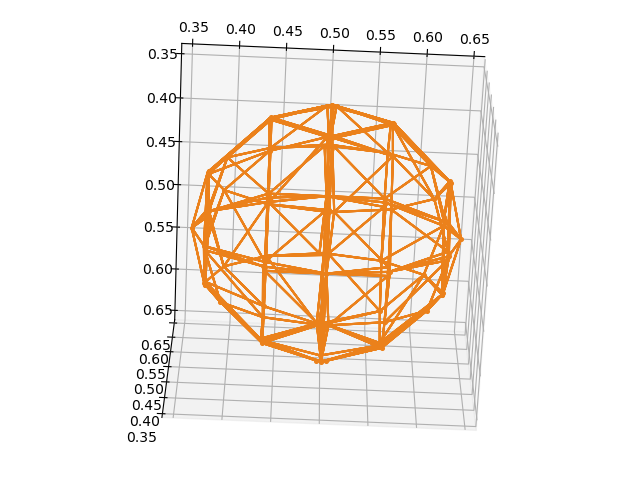

(<Figure size 640x480 with 1 Axes>, <Axes3D:>, None, None)

In [121]:
HC.plot_complex()

In [122]:
corners       = cell_corners_and_intersections[3]["Corners"]
intersections = cell_corners_and_intersections[3]["Intersections"]
corners       = cell_corners_and_intersections[0]["Corners"]
intersections = cell_corners_and_intersections[0]["Intersections"]
p, F_ijk = assign_incides(intersections, corners)
points = intersections[p]
p, F_ijk, points

([0, 2, 1],
 array([[0, 1, 2]]),
 array([[0.375     , 0.43577987, 0.5       ],
        [0.375     , 0.4375    , 0.49514239],
        [0.37388194, 0.4375    , 0.5       ]]))

<IPython.core.display.Javascript object>


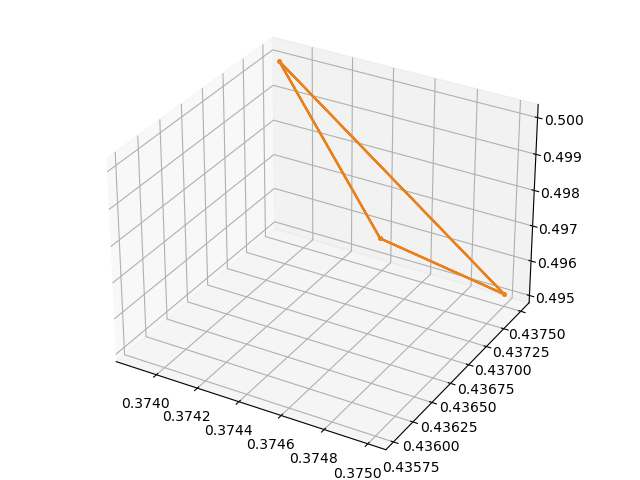

In [123]:
%matplotlib notebook

HC = Complex(3)
points = intersections[p]
for f in F_ijk:
    for fi in f:
        for fj in f:
            vi = HC.V[tuple(points[fi])]
            vj = HC.V[tuple(points[fj])]
            vi.connect(vj)
    
HC.plot_complex()
plt.show()

In [94]:
HNdA_i = []  # total HNdA_i at vertex i
HNdA_ij = []  # total HNdA_i for edge ij
HN_i = []  # point-wise
C_ij = []
alpha_ij = []
for v in HC.V:
    N_f0 = v.x_a - np.array([0.0, 0.0, 1.0])  # First approximation
    N_f0 = normalized(N_f0)[0]
    F, nn = vectorise_vnn(v)
    # Compute discrete curvatures
    c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0)
    # Append lists
    c_outd['HNdA_ij']
    HNdA_ij.append(c_outd['HNdA_ij'])
    HNdA_i.append(c_outd['HNdA_i'])
    HN_i.append(c_outd['HN_i'])
    C_ij.append(c_outd['C_ij'])
    alpha_ij.append(c_outd['alpha_ij'])
    #Theta_i_jk.append(c_outd['Theta_i_jk'])
    #break
    
   #[0]  
# HNdA_i = 0.5 * np.sum(HNdA_ij, axis=0)
# HN_i = np.sum(HNdA_i) / np.sum(C_ij)

HNdA_ij, HN_i, HNdA_i, C_ij, alpha_ij

([array([[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.00021186, -0.00059828],
         [-0.00259934,  0.00399908,  0.        ]], dtype=float64),
  array([[ 0.        ,  0.        ,  0.        ],
         [ 0.        , -0.00021186,  0.00059828],
         [-0.00032594,  0.        ,  0.00141612]], dtype=float64),
  array([[ 0.        ,  0.        ,  0.        ],
         [ 0.00259934, -0.00399908,  0.        ],
         [ 0.00032594,  0.        , -0.00141612]], dtype=float64)],
 [466.217011510043, -611.7590783586478, 16.075570364639347],
 [array([-0.00129967,  0.00210547, -0.00029914], dtype=float64),
  array([-0.00016297, -0.00010593,  0.0010072 ], dtype=float64),
  array([ 0.00146264, -0.00199954, -0.00070806], dtype=float64)],
 [array([0.00000000e+00, 4.08830670e-07, 1.22314555e-06]),
  array([0.00000000e+00, 4.08830670e-07, 9.05420898e-07]),
  array([0.00000000e+00, 1.22314555e-06, 9.05420898e-07])],
 [0.40621011036662785, 1.287132771196474, 1.287132771196474])

# Cotan Laplace weights

In [95]:
L_ij = distance_matrix(points, points)  # Validated, but some floating errors!
L_ij, points, F_ijk

(array([[1.49011612e-08, 5.15318027e-03, 2.05156524e-03],
        [5.15318027e-03, 0.00000000e+00, 4.98462326e-03],
        [2.05156524e-03, 4.98462326e-03, 0.00000000e+00]]),
 array([[0.375     , 0.43577987, 0.5       ],
        [0.375     , 0.4375    , 0.49514239],
        [0.37388194, 0.4375    , 0.5       ]]),
 array([[0, 1, 2]]))

In [96]:
W_jk = np.zeros_like(L_ij)
hnda = []
n_i = [0, 0, 1]
for ijk in F_ijk:
    for i_t in range(3): # for each corner i of each ijk \in F_ijk do:
        j_t = (i_t + 1) % 3  # j = (i + 1) (mod 3)
        k_t = (i_t + 2) % 3  # k = (i + 2) (mod 3)
        i = ijk[i_t]
        j = ijk[j_t]
        k = ijk[k_t]
        
        # Find the index of the cell intersection:
        l_ij = L_ij[i][j]
        l_jk = L_ij[j][k]
        l_ki = L_ij[k][i]
        
        # Test direction
        e_ij = (points[j] - points[i])
        e_ik = (points[k] - points[i])
        wedge_ij_ik = np.cross(e_ij, e_ik)
        if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
            pass#k, j = j, k
            #wedge_ij_ik = np.cross(E_ij[j], E_ij[k])

        
        # Put lengths into a list:mn
        lengths = [l_ij, l_jk, l_ki]
        # Sort the list, python sorts from the smallest to largest element:
        lengths.sort()
  
        # We must have use a ≥ b ≥ c in floating-point stable Heron's formula:
        a = lengths[2]
        b = lengths[1]
        c = lengths[0]
        A = (1/4.0) * np.sqrt((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c)) )

        # w_jk computes 1/2 cot(theta_i^jk) :
        # Elsewhere in paper: 
        # w_ij computes 1/2 cot(theta_i^jk) ?
        w_jk = (1/8.0) * (l_ij**2 + l_ki**2 - l_jk**2)/A
        W_jk[j][k] = w_jk
        #hnda_ijk =  w_jk * (points[j] - points[k]) # curvature from this edge jk in tringle ijk with w_jk = 1/2 cot(theta_i^jk)
        hnda_ijk =  w_jk * (points[k] - points[j]) # curvature from this edge jk in tringle ijk with w_jk = 1/2 cot(theta_i^jk)
        
        
        # (W_jk[0][1] + W_jk[0][2])  * (points[1] - points[0])
        
        hnda.append(hnda_ijk)
        
hnda = np.array(hnda)
W_jk, hnda

(array([[0.        , 0.06158186, 0.        ],
        [0.        , 0.        , 0.14576251],
        [1.16243176, 0.        , 0.        ]]),
 array([[-0.00016297,  0.        ,  0.00070806],
        [ 0.00129967, -0.00199954,  0.        ],
        [ 0.        ,  0.00010593, -0.00029914]]))

In [97]:
0.5 * np.sum(hnda, axis=0), np.sum(HNdA_i, axis=0)#  HNdA_i#, HNdA_ij

(array([ 0.00056835, -0.0009468 ,  0.00020446]),
 array([ 0.00000000e+00,  0.00000000e+00, -1.08420217e-19], dtype=float64))

In [98]:
HNdA_i

[array([-0.00129967,  0.00210547, -0.00029914], dtype=float64),
 array([-0.00016297, -0.00010593,  0.0010072 ], dtype=float64),
 array([ 0.00146264, -0.00199954, -0.00070806], dtype=float64)]

In [99]:
-0.00129967 -0.00016297 + 0.00146264

2.168404344971009e-19

In [100]:
np.sum(HNdA_ij), np.sum(HNdA_i)

(-6.505213034913027e-19, 1.0842021724855044e-19)

In [101]:
HC.V.merge_all(1e-8)
HC.V.size()

3